# VL5: Wahrscheinlichkeit & Verteilungen

### Set-Up

In [31]:
# Grundlegende Bibliotheken
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import kagglehub
import statsmodels.api as sm
from scipy import stats
import numpy as np
import missingno as msno

# Einstellungen für bessere Plots
plt.rcParams['figure.figsize'] = (10, 6)

# Pandas Optionen
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.float_format', '{:.4f}'.format)

# Download latest version

path = kagglehub.dataset_download("priyamchoksi/credit-card-transactions-dataset")

ds = pd.read_csv(f"{path}/credit_card_transactions.csv")

print(f"Anzahl Zeilen: {ds.shape[0]}")
print(f"Anzahl Spalten: {ds.shape[1]}")

Anzahl Zeilen: 1296675
Anzahl Spalten: 24


# Satz von Bayes

Das Baye'sche Denken mit Information denkt so, dass sich unsere Einschätzung, ob eine Transaktion Betrug ist, verändert, sobald wir neue Evidenz erhalten (z.B. der Betrag ist sehr hoch). Dies möchten wir gerne an einem Szenario darstellen: Der Prior $P(Fraud)$, d.h. die Grundwarscheinlichkeit für Fraud ist der Mittelwert der Fraud-Spalte, die Evidenz $E$ ist, dass die Transaktion höher als 500 Dollar beträgt. Nun brauchen wir noch die Likelihood $P(E | Fraud)$, d.h. wie oft Betrüger mehr als 500 Dollar ausgeben, und können daraus den Posterior $P(Fraud|E)$ berechnen, d.h. wie hoch ist das Risiko nach Beobachtung dieses Transaktionsbetrags.

Prior Wahrscheinlichkeit (Blind): 0.5789%
Posterior Wahrscheinlichkeit (nach Wissen 'Betrag > $500'): 23.3382%


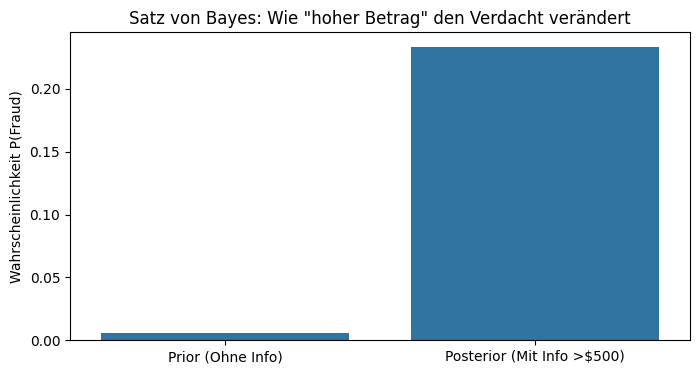

In [40]:
# Definieren der Evidenz: Hoher Betrag (> 500 USD)
limit = 500
ds['high_amount'] = ds['amt'] > limit

# Berechnung der Komponenten für Bayes
p_fraud = ds['is_fraud'].mean()  # Prior: P(Fraud)
p_high = ds['high_amount'].mean() # Evidenz: P(High Amount)

# Likelihood: P(High Amount | Fraud)
p_high_given_fraud = ds.loc[ds['is_fraud'] == 1, 'high_amount'].mean()

# Satz von Bayes anwenden
# P(Fraud | High Amount) = (P(High | Fraud) * P(Fraud)) / P(High)
p_fraud_given_high = (p_high_given_fraud * p_fraud) / p_high

print(f"Prior Wahrscheinlichkeit (Blind): {p_fraud:.4%}")
print(f"Posterior Wahrscheinlichkeit (nach Wissen 'Betrag > $500'): {p_fraud_given_high:.4%}")

# Visualisierung des 'Information Gain'
plt.figure(figsize=(8, 4))
sns.barplot(x=['Prior (Ohne Info)', 'Posterior (Mit Info >$500)'], y=[p_fraud, p_fraud_given_high])
plt.title(f'Satz von Bayes: Wie "hoher Betrag" den Verdacht verändert')
plt.ylabel('Wahrscheinlichkeit P(Fraud)')
plt.show()

Wir sehen also, dass die Information über einen hohen Transaktionsbetrag die Unsicherheit stark reduziert, und unsere Wahrscheinlichkeit für Betrug somit stark erhöht von unter 1% auf über 23%.

# Bedingte Wahrscheinlichkeiten

### Eine Bedingung

##### Wahrscheinlichkeit für Betrug gegeben ein Geschlecht

In [32]:
# Grundwahrscheinlichkeiten
p_fraud = ds["is_fraud"].mean()
p_male  = (ds["gender"] == "M").mean()
p_female = (ds["gender"] == "F").mean()

# P(Male | Fraud)
p_male_given_fraud = ds.loc[ds["is_fraud"] == 1, "gender"].eq("M").mean()
p_female_given_fraud = ds.loc[ds["is_fraud"] == 1, "gender"].eq("F").mean()

# Bayes: P(Fraud | Male) und P(Fraud | Female)
p_fraud_given_male = (p_male_given_fraud * p_fraud) / p_male
p_fraud_given_female = (p_female_given_fraud * p_fraud) / p_female

print("Bedingte Wahrscheinlichkeiten:")
print(f"P(Fraud | Male)   = {p_fraud_given_male:.3%}")
print(f"P(Fraud | Female) = {p_fraud_given_female:.3%}")

# Risiko-Mass: Risk Ratio (Relatives Risiko)
risk_ratio = p_fraud_given_male / p_fraud_given_female
print(f"\nRisikomass (Risk Ratio) Männer vs. Frauen: {risk_ratio:.3f}")

Bedingte Wahrscheinlichkeiten:
P(Fraud | Male)   = 0.643%
P(Fraud | Female) = 0.526%

Risikomass (Risk Ratio) Männer vs. Frauen: 1.221


##### Wahrscheinlichkeit für Betrug gegeben eine Kategorie

Risikomasse nach Kategorie:
                P(Fraud|Category)  Risk Difference  Risk Ratio  Odds Ratio
category                                                                  
shopping_net               0.0176           0.0118      3.0338      3.0701
misc_net                   0.0145           0.0087      2.4976      2.5196
grocery_pos                0.0141           0.0083      2.4354      2.4559
shopping_pos               0.0072           0.0014      1.2482      1.2500
gas_transport              0.0047          -0.0011      0.8109      0.8100
misc_pos                   0.0031          -0.0027      0.5422      0.5407
grocery_net                0.0029          -0.0028      0.5093      0.5078
travel                     0.0029          -0.0029      0.4947      0.4933
entertainment              0.0025          -0.0033      0.4281      0.4267
personal_care              0.0024          -0.0034      0.4188      0.4173
kids_pets                  0.0021          -0.0037      0.3653      0.36

/var/folders/cd/nv3twvx12gx_b15k3sbqkn300000gn/T/ipykernel_44373/1615279345.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


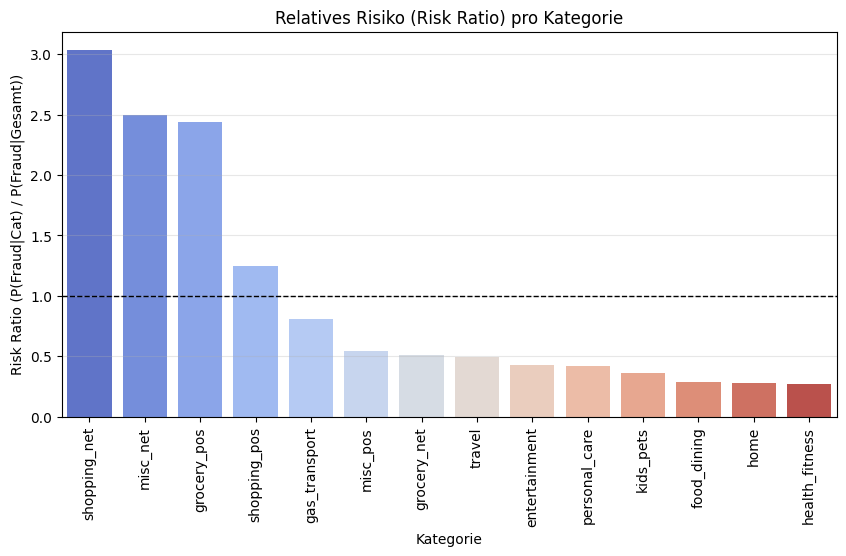

In [33]:
# Grundwahrscheinlichkeit
p_fraud_overall = ds["is_fraud"].mean()

# Betrugswahrscheinlichkeit pro Kategorie
fraud_by_cat = ds.groupby("category")["is_fraud"].mean().sort_values(ascending=False)

# Risikomaße berechnen
risk_df = pd.DataFrame({
    "P(Fraud|Category)": fraud_by_cat,
    "Risk Difference": fraud_by_cat - p_fraud_overall,
    "Risk Ratio": fraud_by_cat / p_fraud_overall,
    "Odds Ratio": (fraud_by_cat / (1 - fraud_by_cat)) / (p_fraud_overall / (1 - p_fraud_overall))
})

print("Risikomasse nach Kategorie:")
print(risk_df.round(4))

# Visualisierung: Relative Risiken (RR)
plt.figure(figsize=(10,5))
sns.barplot(
    x=risk_df.index,
    y="Risk Ratio",
    data=risk_df,
    palette="coolwarm"
)
plt.title("Relatives Risiko (Risk Ratio) pro Kategorie")
plt.xlabel("Kategorie")
plt.ylabel("Risk Ratio (P(Fraud|Cat) / P(Fraud|Gesamt))")
plt.xticks(rotation=90)
plt.axhline(1, color="black" ,linestyle="--", linewidth=1)
plt.grid(axis="y", alpha=0.3)
plt.show()

##### Wahrscheinlichkeit für Betrug gegeben ein Beruf

Risikomasse nach Beruf (Top 10):
                                                    P(Fraud|Job)  \
job                                                                
Personnel officer                                         1.0000   
Air traffic controller                                    1.0000   
Accountant, chartered                                     1.0000   
Ship broker                                               1.0000   
Solicitor                                                 1.0000   
Careers adviser                                           1.0000   
Information officer                                       1.0000   
Armed forces technical officer                            1.0000   
Industrial buyer                                          1.0000   
Homeopath                                                 1.0000   
Legal secretary                                           1.0000   
Forest/woodland manager                                   1.0000   
Dancer         

/var/folders/cd/nv3twvx12gx_b15k3sbqkn300000gn/T/ipykernel_44373/2635030265.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


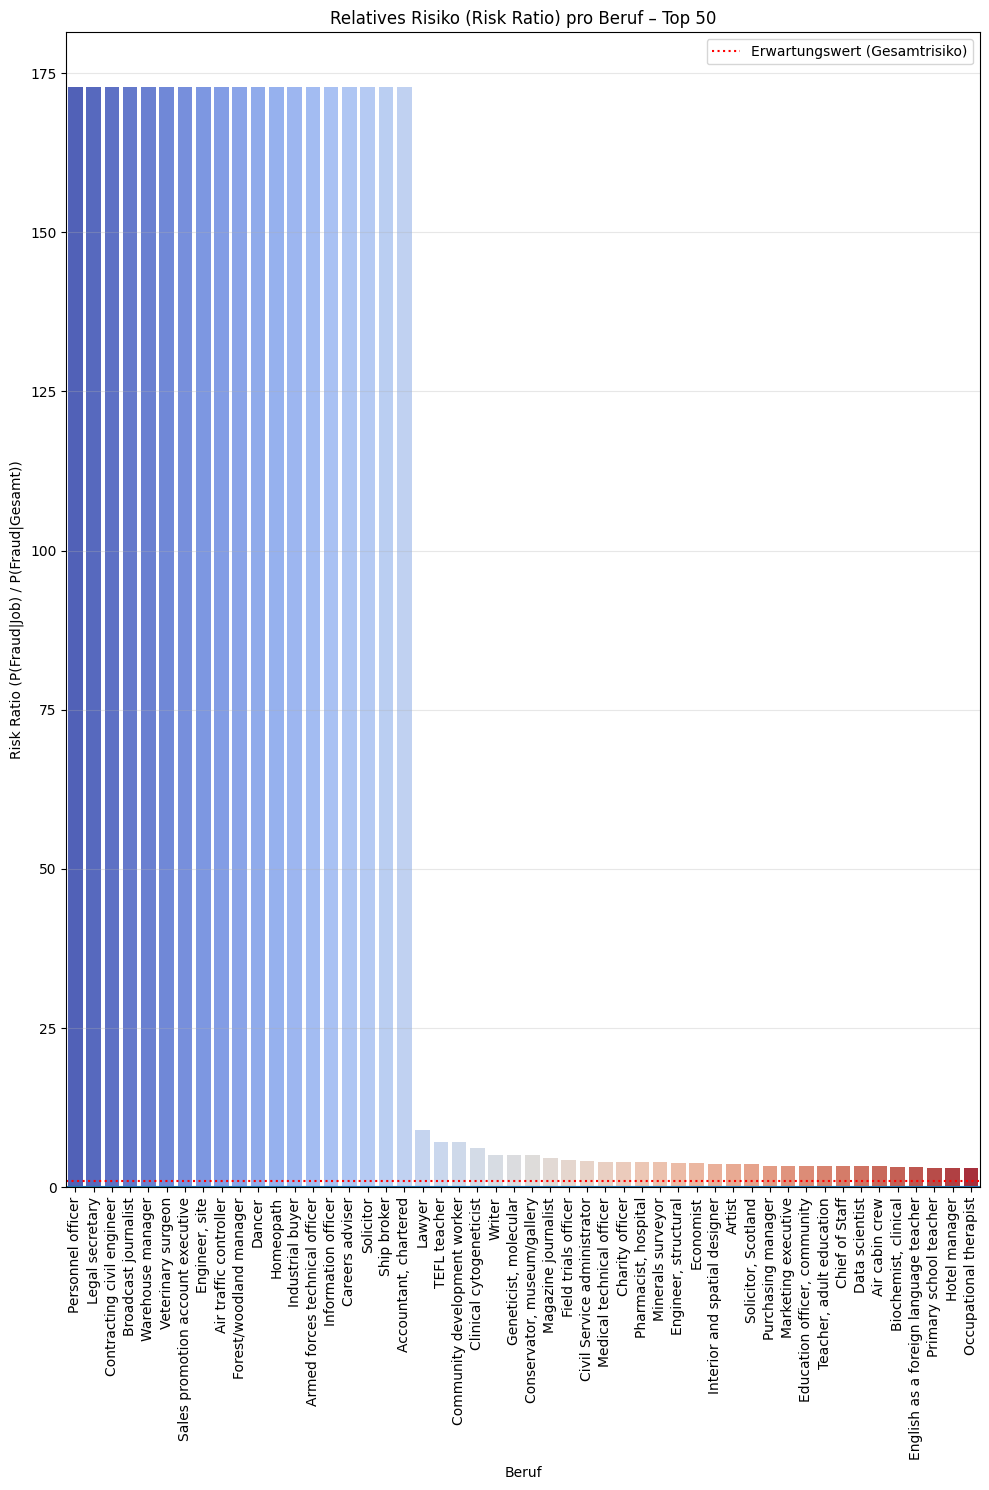

In [34]:
# Grundwahrscheinlichkeit
p_fraud_overall = ds["is_fraud"].mean()

# Betrugswahrscheinlichkeit pro Beruf 
fraud_by_job = ds.groupby("job")["is_fraud"].mean().sort_values(ascending=False)

# Risikomaße berechnen
risk_job = pd.DataFrame({
    "P(Fraud|Job)": fraud_by_job,
    "Risk Difference": fraud_by_job - p_fraud_overall,
    "Risk Ratio": fraud_by_job / p_fraud_overall,
    "Odds Ratio": (fraud_by_job / (1 - fraud_by_job)) / (p_fraud_overall / (1 - p_fraud_overall))
}).round(6)

print("Risikomasse nach Beruf (Top 10):")
pd.set_option('display.max_rows',risk_job.shape[0])
print(risk_job.head(risk_job.shape[0]))

# Visualisierung: Top 15 Berufe nach Risk Ratio 
top_jobs = risk_job.head(50).reset_index()

plt.figure(figsize=(10,15))
sns.barplot(
    data=top_jobs,
    x="job",
    y="Risk Ratio",
    palette="coolwarm",
    order=top_jobs.sort_values("Risk Ratio", ascending=False)["job"]
)
plt.title("Relatives Risiko (Risk Ratio) pro Beruf – Top 50")
plt.xlabel("Beruf")
plt.ylabel("Risk Ratio (P(Fraud|Job) / P(Fraud|Gesamt))")
plt.xticks(rotation=90)
plt.axhline(y=p_fraud_overall / p_fraud_overall, color="red", linestyle=":", linewidth=1.5, label="Erwartungswert (Gesamtrisiko)")
plt.legend()
plt.grid(axis="y", alpha=0.3)
plt.axhline()
plt.tight_layout()
plt.show()

### Mehrere Bedingungen

##### Betrugsrisiko bei Mann UND Online-Handel

In [35]:
# Kategorien mit "_net" sind Online-Transaktionen
ds['is_online'] = ds['category'].str.contains('_net', case=False)

# 2. Berechnung der bedingten Wahrscheinlichkeit
# P(Fraud | Gender=M AND Online=True)
subset_male_online = ds[(ds['gender'] == 'M') & (ds['is_online'] == True)]
p_fraud_given_male_online = subset_male_online['is_fraud'].mean()

print(f"P(Fraud | Male, Online):\t{p_fraud_given_male_online:.3%}")

# Vergleich: Wie ist es bei Frauen im Online-Handel?
subset_female_online = ds[(ds['gender'] == 'F') & (ds['is_online'] == True)]
p_fraud_given_female_online = subset_female_online['is_fraud'].mean()

print(f"P(Fraud | Female, Online):\t{p_fraud_given_female_online:.3%}")

P(Fraud | Male, Online):	1.807%
P(Fraud | Female, Online):	0.976%


Wir sehen also, dass die Bedingung "Online" in beiden Fällen die Wahrscheinlichkeit für Betrug erhöht. Ebenso erkennen wir, dass die männliche Bedingung weiterhin eine höhere Wahrscheinlichkeit für Betrug mit sich bringt, dieser Unterschied ist nun sogar noch grösser zwischen den Geschlechtern als wenn wir keine Bedingung an Online/Offline stellen.

# Verteilungen

### Log-Normalverteilung

Wie bereits zu Beginn des Projekts erwähnt, sind unsere Transaktionsbeträge typisch sehr rechtsschief, d.h. wir haben viele kleine Beträge, und wenige riesige. Somit transformieren wir diese jeweils logarithmisch, um diese starke Schiefe etwas normalverteilter zu machen. Um zu sehen, ob unsere Daten nach der Transformation wirklich log-normalverteilt sind, schauen wir uns deren Verteilung in einem KDE-Plot an und unterscheiden zwischen Betrug und legitimen Transaktionen, um Unterschiede in der Verteilung erkennen zu können.

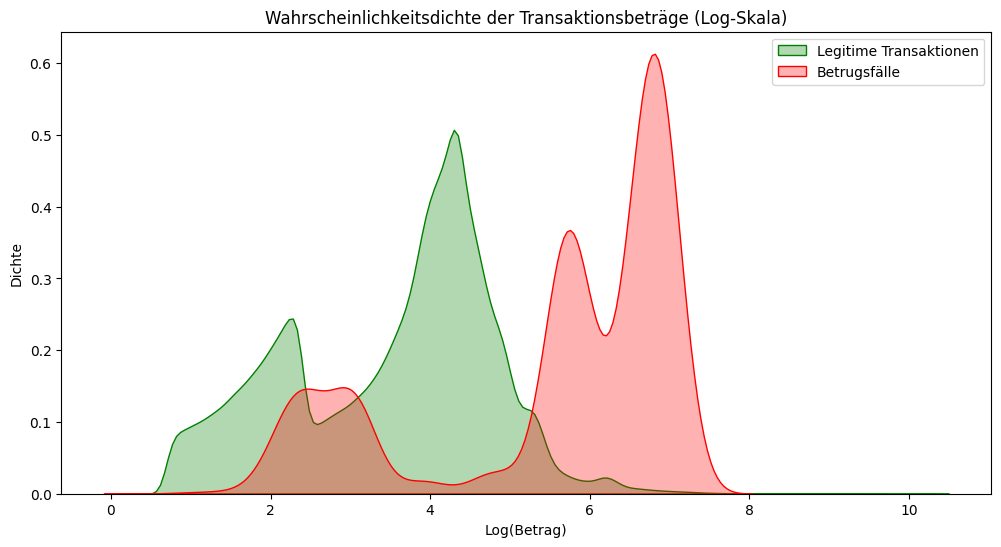

In [38]:
# Wir filtern 0-Beträge raus (falls vorhanden) und log-transformieren
fraud_amts = ds[ds['is_fraud'] == 1]['amt']
normal_amts = ds[ds['is_fraud'] == 0]['amt']

plt.figure(figsize=(12, 6))

# Log-Transformation für bessere Sichtbarkeit
# Wir nutzen KDE (Kernel Density Estimation) um die Form der Verteilung zu zeigen
sns.kdeplot(np.log1p(normal_amts), label='Legitime Transaktionen', fill=True, color='green', alpha=0.3)
sns.kdeplot(np.log1p(fraud_amts), label='Betrugsfälle', fill=True, color='red', alpha=0.3)

plt.title('Wahrscheinlichkeitsdichte der Transaktionsbeträge (Log-Skala)')
plt.xlabel('Log(Betrag)')
plt.ylabel('Dichte')
plt.legend()
plt.show()

Wir sehen keine perfekte log-Normalverteilung mit Glockenform, sondern eher eine bimodale Verteilung mit einem Dichte-Peak bei niedrigen Beträgen und einem höheren Peak (bzw. 2 im Falle von Betrug) bei höheren Beträgen. Wir sehen zudem, dass Betrusgfälle eine etwas andere Verteilung aufweisen: Einerseits gibt es bei den logarithmischen Beträgen zwischen 2 und 4 einen "Bucket", weiter haben sie oft höhere Beträge als normale Einkäufe. Wir könnten diese Erkenntnis vielleicht später sogar als Basis für statistische Anomalie-Erkennung nutzen. Sie sind insofern aber ähnlich verteilt, dass sie 2 signifikante "Dichte-Peaks" aufweisen wie die Verteilung der legitimen Transaktionen, nur eben bei höheren Transaktionsbeträgen.

### Poisson

Poisson-Verteilungen treten oft bei seltenen Ereignissen in einem Zeitintervall auf. Wir denken, dass sich dies super auf Betrugsfälle anwenden lässt, weshalb wir nun überprüfen, ob die Anzahl der Betrugsfälle pro Tag einer Poisson-Verteilung folgt

Geschätztes Lambda (Durchschn. Betrugsfälle/Tag): 14.89


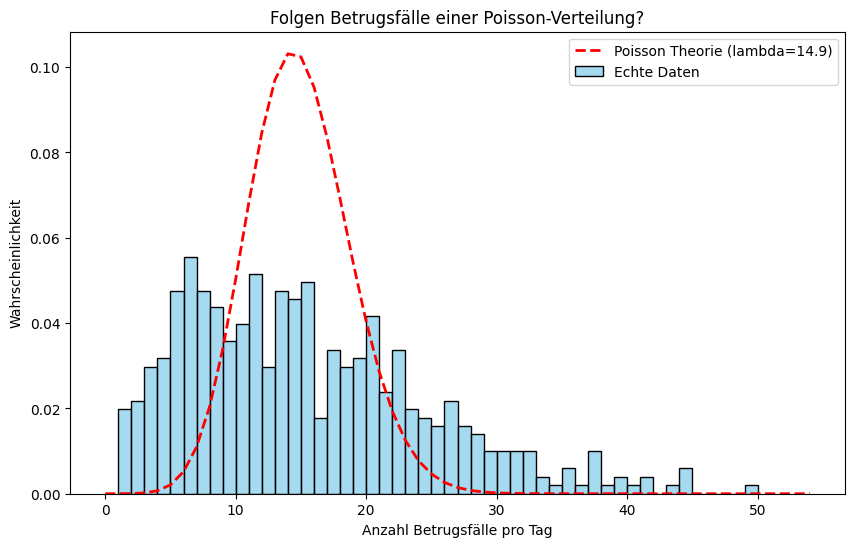

In [36]:
from scipy.stats import poisson

# Betrugsfälle pro Tag zählen
ds['trans_date_trans_time'] = pd.to_datetime(ds['trans_date_trans_time'])
fraud_per_day = ds[ds['is_fraud'] == 1].groupby(ds['trans_date_trans_time'].dt.date)['is_fraud'].count()

# Lambda schätzen
lambda_est = fraud_per_day.mean()
print(f"Geschätztes Lambda (Durchschn. Betrugsfälle/Tag): {lambda_est:.2f}")

# Visualisierung: Empirische Daten vs. Theoretische Poisson-Verteilung
plt.figure(figsize=(10, 6))

# Histogramm der echten Daten
sns.histplot(fraud_per_day, stat='density', label='Echte Daten', color='skyblue', binwidth=1)

# Theoretische Poisson-Kurve
k = np.arange(0, fraud_per_day.max() + 5)
plt.plot(k, poisson.pmf(k, lambda_est), 'r--', lw=2, label=f'Poisson Theorie (lambda={lambda_est:.1f})')

plt.title('Folgen Betrugsfälle einer Poisson-Verteilung?')
plt.xlabel('Anzahl Betrugsfälle pro Tag')
plt.ylabel('Wahrscheinlichkeit')
plt.legend()
plt.show()

Wir sehen, die täglichen Betrugsfälle folgen ein klein wenig einer Poisson-Verteilung (konstantes Grundrisiko), es gibt aber deutliche Ausreisser nach oben und das Histgramm ist "breiter" als die Kurve, d.h. es gibt also mehr Tage mit sehr wenig Betrug und mehr Tage mit mehr Betrug als erwartet. Wir denken, dass dies damit zu tun haben könnte, das Betrugsfälle oftmals in Wellen auftreten ("Bursting-Behaviour"), womit es an einem Tag plötzlich viele Fälle geben kann, und am nächsten Tag nur wenige. Somit ist die Unbahängigkeits-Annahme verletzt.

### Binomial-Verteilung

Wir stellen uns ein Szenario vor, wo ein Auditor 100 Transaktionen zufällig manuell prüft. Wir möchten gerne wissen und darstellen, wie wahrscheinlich es ist, dass er dabei keinen einzigen Betrugsfall findet.

Bei 100 geprüften Transaktionen erwarten wir im Schnitt 0.58 Betrugsfälle.
Wahrscheinlichkeit, gar keinen Betrug zu finden (k=0): 55.96%


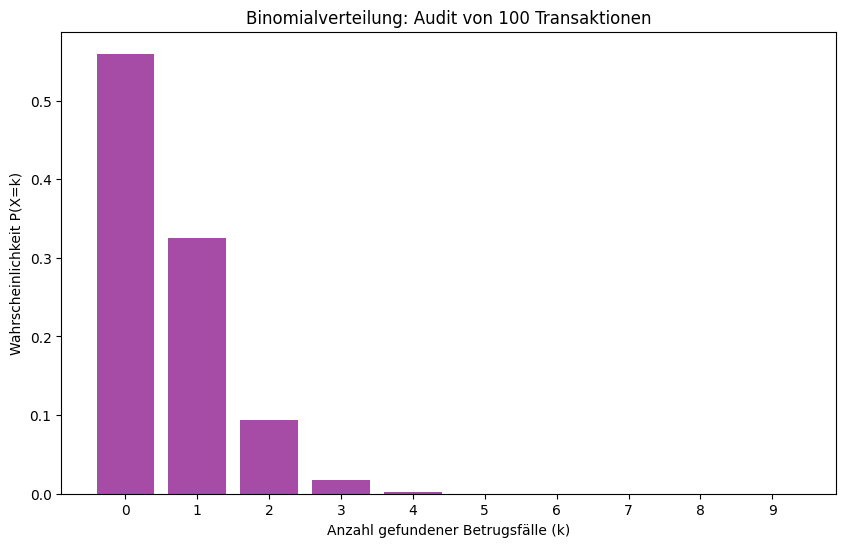

In [41]:
from scipy.stats import binom

# Szenario: Prüfen n = 100 Transaktionen
n = 100
p = ds['is_fraud'].mean() # "Erfolgswahrscheinlichkeit" (Betrug)

# Wahrscheinlichkeit für genau k Treffer berechnen
k_values = range(0, 10) # Wir schauen uns 0 bis 9 Treffer an
probs = [binom.pmf(k, n, p) for k in k_values]

# Visualisierung
plt.figure(figsize=(10, 6))
plt.bar(k_values, probs, color='purple', alpha=0.7)
plt.title(f'Binomialverteilung: Audit von {n} Transaktionen')
plt.xlabel('Anzahl gefundener Betrugsfälle (k)')
plt.ylabel('Wahrscheinlichkeit P(X=k)')
plt.xticks(k_values)

# Beispiel-Interpretation im Text
expected_val = n * p
print(f"Bei {n} geprüften Transaktionen erwarten wir im Schnitt {expected_val:.2f} Betrugsfälle.")
print(f"Wahrscheinlichkeit, gar keinen Betrug zu finden (k=0): {binom.pmf(0, n, p):.2%}")
plt.show()

# Erwartungswert & Law of Large Numbers (LLN)

### Finanzieller Verlust pro Transaktion

In unserem Kontext von Kreditkartenbetrug sehen wir den "erwarteten Verlust pro Transaktion" als einen Erwartungswert. Mittels des Gesetz der grossen Zahlen möchten wir gerne visualisieren, dass sich der Durchschnitt dieses Erwartungswerts bei vielen Beobachtungen stabilisiert.

Erwarteter Verlust pro Transaktion (E[L]): $3.0756


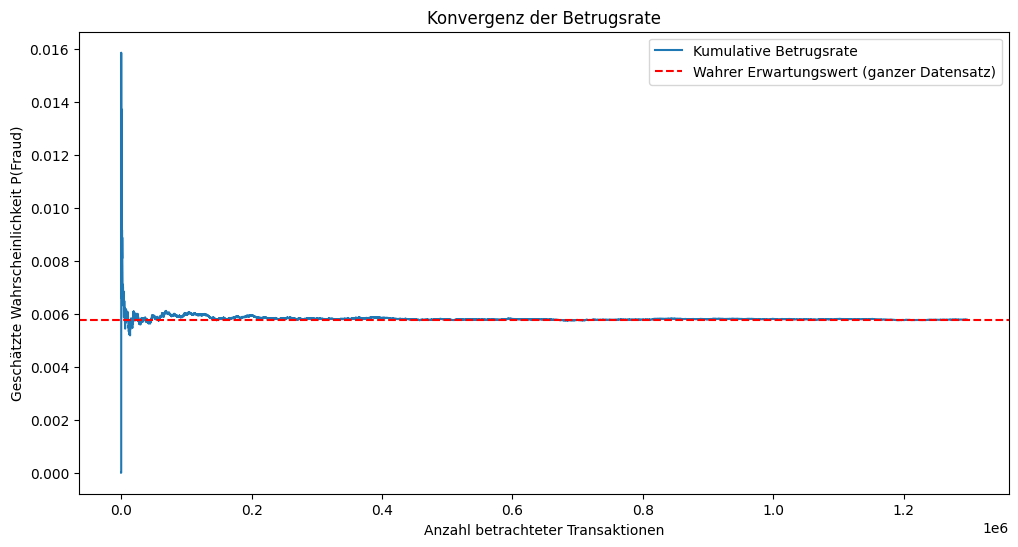

In [37]:
# Erwartungswert des Verlustes pro Transaktion
# E[Loss] = P(Fraud) * Durchschnittlicher_Betrag_bei_Fraud
# Wenn kein Fraud -> Verlust 0. Wenn Fraud -> Verlust = Amt.
expected_loss_per_trans = (ds['is_fraud'] * ds['amt']).mean()

print(f"Erwarteter Verlust pro Transaktion (E[L]): ${expected_loss_per_trans:.4f}")

# Law of Large Numbers Visualisierung
# Wir zeigen, wie sich die geschätzte Betrugsrate stabilisiert, je mehr Daten wir ansehen
np.random.seed(42)
# Wir mischen die Daten, um eine zufällige Eingangsreihenfolge zu simulieren
shuffled_fraud = ds['is_fraud'].sample(frac=1).reset_index(drop=True)

# Berechnen des kumulativen Mittelwerts
cumulative_mean = shuffled_fraud.expanding().mean()

plt.figure(figsize=(12, 6))
plt.plot(cumulative_mean, label='Kumulative Betrugsrate')
plt.axhline(ds['is_fraud'].mean(), color='red', linestyle='--', label='Wahrer Erwartungswert (ganzer Datensatz)')
plt.title('Konvergenz der Betrugsrate')
plt.xlabel('Anzahl betrachteter Transaktionen')
plt.ylabel('Geschätzte Wahrscheinlichkeit P(Fraud)')
plt.legend()
plt.show()

Wir sehen hier sehr schön, wie mit steigender Anzahl betrachteter Transaktion die kumulierte Betrugsrate immer besser den wahren Erwartungswert über den ganzen Datensatz annähernd und langsam zu diesem konvergiert.